In [186]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import datetime
import math
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

In [187]:
from tensorflow.keras import mixed_precision

# # Set the global policy to mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [188]:
# import os

# # Set the environment variable
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [189]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [190]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


I0000 00:00:1728925008.497337    5131 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728925008.500545    5131 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728925008.502787    5131 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728925008.504885    5131 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [191]:
# data = pd.read_csv("C:\Users\alanx\OneDrive - The University of Sydney (Students)\Thesis\Deep Learning\wifi_localization\data\csv\ultimate_combined.csv")
# data = pd.read_csv("data/csv/ultimate_combined.csv")
data = pd.read_csv("data/csv/still/still.csv")
# data = pd.read_csv("data/csv/still_with_receiver/still_with_receiver.csv")

data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,with_receiver,coord1,coord2,ant1_amplitude_cluster,ant2_amplitude_cluster
0,1,-0.910605,-0.551767,-0.947813,1,0.080161,0.716936,1.632341,0.081637,0,6,2,0.0,1.0
1,1,-0.910605,-0.551767,-0.947813,2,0.050665,0.765282,1.613039,0.069161,0,6,2,0.0,1.0
2,1,-0.910605,-0.551767,-0.947813,3,0.034689,0.716998,1.575497,0.066240,0,6,2,0.0,1.0
3,1,-0.910605,-0.551767,-0.947813,4,-0.014982,0.698775,1.568640,0.054993,0,6,2,0.0,1.0
4,1,-0.910605,-0.551767,-0.947813,5,-0.038545,0.842687,1.580335,0.041922,0,6,2,0.0,1.0


In [192]:
data.drop('with_receiver', axis=1, inplace=True)
data.drop('nc', axis=1, inplace=True)
data.drop('ant1_phase', axis=1, inplace=True)
data.drop('ant2_phase', axis=1, inplace=True)

In [193]:
data = pd.concat([data, pd.get_dummies(data['subcarriers'], prefix='subcarrier')], axis=1)
data.drop('subcarriers', axis=1, inplace=True)
data.head()

,rssi,rssi1,rssi2,ant1_amplitude,ant2_amplitude,coord1,coord2,ant1_amplitude_cluster,ant2_amplitude_cluster,subcarrier_1,...,subcarrier_47,subcarrier_48,subcarrier_49,subcarrier_50,subcarrier_51,subcarrier_52,subcarrier_53,subcarrier_54,subcarrier_55,subcarrier_56
0,-0.910605,-0.551767,-0.947813,0.080161,0.716936,6,2,0.0,1.0,True,...,False,False,False,False,False,False,False,False,False,False
1,-0.910605,-0.551767,-0.947813,0.050665,0.765282,6,2,0.0,1.0,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.910605,-0.551767,-0.947813,0.034689,0.716998,6,2,0.0,1.0,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.910605,-0.551767,-0.947813,-0.014982,0.698775,6,2,0.0,1.0,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.910605,-0.551767,-0.947813,-0.038545,0.842687,6,2,0.0,1.0,False,...,False,False,False,False,False,False,False,False,False,False


In [194]:
data_nc1 = data.loc[data['nc'] == 1].copy()
data_nc2 = data.loc[data['nc'] == 2].copy()

KeyError: 'nc'

# Model

In [163]:
model_type = "dnn-combined"

In [ ]:
X_nc1 = data_nc1.drop(columns=['coord1', 'coord2']) 
y_nc1 = data_nc1[['coord1', 'coord2']]

In [164]:
X_nc2 = data_nc2.drop(columns=['coord1', 'coord2']) 
y_nc2 = data_nc2[['coord1', 'coord2']]

# X = X.values.astype(np.float32)
# y = y.values.astype(np.float32)

In [165]:
# np.save('preprocessed_X.npy', X)
# np.save('preprocessed_y.npy', y)

In [166]:
# X = np.load('preprocessed_X.npy')
# y = np.load('preprocessed_y.npy')

In [167]:
# dataset = tf.data.Dataset.from_tensor_slices((X, y))

# batch_size = 128  # Adjust based on your GPU memory

# dataset = dataset.shuffle(buffer_size=10000)
# dataset = dataset.batch(batch_size)
# dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Split data_nc1 into training and temporary sets (for validation and testing)
X_nc1_train, X_nc1_temp, y_nc1_train, y_nc1_temp = train_test_split(X_nc1, y_nc1, test_size=0.4, random_state=42)  # 60% train, 40% temp
# Split the temporary set into validation and test sets
X_nc1_val, X_nc1_test, y_nc1_val, y_nc1_test = train_test_split(X_nc1_temp, y_nc1_temp, test_size=0.5, random_state=42)  # 20% val, 20% test

print("NC=1 Training set shape:", X_nc1_train.shape)
print("NC=1 Validation set shape:", X_nc1_val.shape)
print("NC=1 Test set shape:", X_nc1_test.shape)

In [168]:
# Split data_nc2 into training and temporary sets (for validation and testing)
X_nc2_train, X_nc2_temp, y_nc2_train, y_nc2_temp = train_test_split(X_nc2, y_nc2, test_size=0.4, random_state=42)  # 60% train, 40% temp
# Split the temporary set into validation and test sets
X_nc2_val, X_nc2_test, y_nc2_val, y_nc2_test = train_test_split(X_nc2_temp, y_nc2_temp, test_size=0.5, random_state=42)  # 20% val, 20% test

# Check the shapes of your splits
print("NC=2 Training set shape:", X_nc2_train.shape)
print("NC=2 Validation set shape:", X_nc2_val.shape)
print("NC=2 Test set shape:", X_nc2_test.shape)

Training set shape: (305328, 63)
Validation set shape: (101776, 63)
Test set shape: (101777, 63)


In [169]:
def create_dnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))

    # Hidden layers
    # model.add(layers.Dense(8192, activation='relu'))
    # model.add(layers.Dense(4096, activation='relu'))
    # model.add(layers.Dense(2048, activation='relu'))
    # model.add(layers.Dense(2048, activation='relu'))
    # model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    # model.add(layers.Dense(256, activation='relu'))
    # model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dense(16, activation='relu'))

    # Output layer
    model.add(layers.Dense(2))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 1024)           │        65,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,641,474 (6.26 MB)

 Trainable params: 1,641,474 (6.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
input_shape_nc1 = (X_nc1_train.shape[1],)
model_nc1 = create_dnn_model(input_shape_nc1)

# Print the model summary
model_nc1.summary()

In [ ]:
input_shape_nc2 = (X_nc2_train.shape[1],)
model_nc2 = create_dnn_model(input_shape_nc2)

# Print the model summary
model_nc2.summary()

In [170]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
# Train the model
with tf.device('/GPU:0'):
    history_nc1 = model_nc1.fit(
                        # dataset,
                        X_nc1_train, y_nc1_train, 
                        epochs=30, 
                        batch_size=128, 
                        validation_data=(X_nc1_val, y_nc1_val),
                        callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

    # Evaluate the model on test data
    test_loss, test_mae = model_nc1.evaluate(X_nc1_test, y_nc1_test)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


Epoch 1/30
2361/2386 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7862 - mae: 0.7966

2024-10-15 03:05:16.050944: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 20 bytes spill stores, 20 bytes spill loads

2024-10-15 03:05:16.158974: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_215', 16 bytes spill stores, 16 bytes spill loads

2024-10-15 03:05:16.517785: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 368 bytes spill stores, 368 bytes spill loads

2024-10-15 03:05:16.601401: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 200 bytes spill stores, 200 bytes spill loads

2024-10-15 03:05:17.649167: I external/local_xla/xla/stream_

2386/2386 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.7755 - mae: 0.7938 - val_loss: 0.4506 - val_mae: 0.3974
Epoch 2/30
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3347 - mae: 0.3193 - val_loss: 0.2497 - val_mae: 0.2619
Epoch 3/30
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2176 - mae: 0.2360 - val_loss: 0.1798 - val_mae: 0.1962
Epoch 4/30
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1539 - mae: 0.1868 - val_loss: 0.1571 - val_mae: 0.1747
Epoch 5/30
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1156 - mae: 0.1564 - val_loss: 0.1150 - val_mae: 0.1415
Epoch 6/30
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0895 - mae: 0.1323 - val_loss: 0.0904 - val_mae: 0.1158
Epoch 7/30
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0658 - mae: 0.1097 - val_loss: 0.0816 - val_mae: 0.1045
Epoch 8/30
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0585 - mae: 0.1008 - val_loss: 0.0928 - val_mae: 0.1316
Epoch 9/30
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/s

2024-10-15 03:07:30.959782: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 32 bytes spill stores, 32 bytes spill loads

2024-10-15 03:07:31.002988: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 12 bytes spill stores, 12 bytes spill loads

2024-10-15 03:07:31.346501: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 200 bytes spill stores, 200 bytes spill loads



3181/3181 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0280 - mae: 0.0463 
Test Loss: 0.02836517058312893, Test MAE: 0.04572787135839462


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
# Train the model
with tf.device('/GPU:0'):
    history_nc2 = model_nc2.fit(
                        # dataset,
                        X_nc2_train, y_nc2_train, 
                        epochs=30, 
                        batch_size=128, 
                        validation_data=(X_nc2_val, y_nc2_val),
                        callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

    # Evaluate the model on test data
    test_loss, test_mae = model_nc2.evaluate(X_nc2_test, y_nc2_test)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

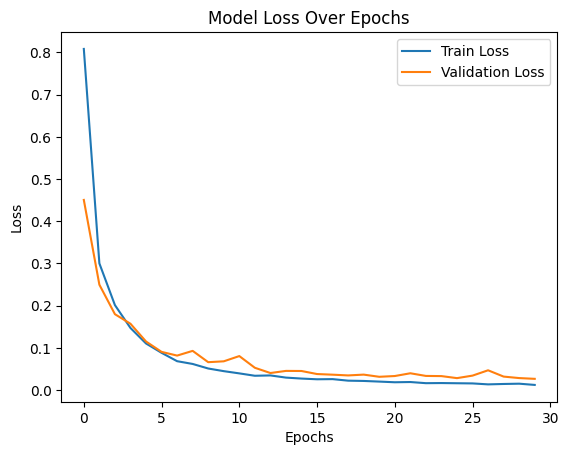

In [171]:
# Plot training & validation loss
plt.plot(history_nc1.history['loss'], label='Train Loss')
plt.plot(history_nc1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Plot training & validation loss
plt.plot(history_nc2.history['loss'], label='Train Loss')
plt.plot(history_nc2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [172]:
# After training your model
# y_pred = model.predict(X_test)

3181/3181 ━━━━━━━━━━━━━━━━━━━━ 3s 725us/step


In [ ]:
# y_pred = 0.5 * model_nc1.predict(X_nc1_test) + 0.5 * model_nc2.predict(X_nc2_test)

In [ ]:
# Combine the training data
X_train = np.concatenate([X_nc1_train, X_nc2_train], axis=0)
y_train = np.concatenate([y_nc1_train, y_nc2_train], axis=0)
X_test = np.concatenate([X_nc1_test, X_nc2_test], axis=0)
y_test = np.concatenate([y_nc1_test, y_nc2_test], axis=0)

In [ ]:
from sklearn.ensemble import StackingRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

dnn_regressor = KerasRegressor(build_fn=create_dnn_model, epochs=30, batch_size=128, verbose=1)

# Create a stacking model
stack_model = StackingRegressor(
    estimators=[('nc1', model_nc1), ('nc2', model_nc2)],
    final_estimator=dnn_regressor  # This could be any model (e.g., linear regressor, DNN)
)

# Train the stacking model
stack_model.fit(X_train, y_train)

# Make predictions with the stacked model
y_pred = stack_model.predict(X_test)

In [173]:
# Convert y_test to NumPy array with float64 data type
y_test_np = y_test.to_numpy(dtype=np.float64)

# Ensure y_pred is a NumPy array with float64 data type
y_pred_np = np.array(y_pred, dtype=np.float64)

In [174]:
# Assuming y_test and y_pred are NumPy arrays
absolute_errors = np.abs(y_test_np - y_pred_np)
coordinate_ranges = np.ptp(y_test_np, axis=0)  # Peak to peak (max - min) along each coordinate

# Avoid division by zero
coordinate_ranges[coordinate_ranges == 0] = 1

relative_errors = absolute_errors / coordinate_ranges
mean_relative_error = np.mean(relative_errors, axis=0)

print(f"Mean Relative Error for coord1: {mean_relative_error[0]:.4f}")
print(f"Mean Relative Error for coord2: {mean_relative_error[1]:.4f}")


Mean Relative Error for coord1: 0.0089
Mean Relative Error for coord2: 0.0076


In [175]:
from scipy.stats import spearmanr

rho_coord1, _ = spearmanr(y_test_np[:, 0], y_pred_np[:, 0])
rho_coord2, _ = spearmanr(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Spearman's Rank Correlation for coord1: {rho_coord1:.4f}")
print(f"Spearman's Rank Correlation for coord2: {rho_coord2:.4f}")


Spearman's Rank Correlation for coord1: 0.9732
Spearman's Rank Correlation for coord2: 0.9501


In [176]:
# Create a mapping from coordinate pairs to class labels
unique_coords = np.unique(y_test_np, axis=0)
coord_to_label = {tuple(coord): idx for idx, coord in enumerate(unique_coords)}

# Convert coordinates to labels
y_test_labels = np.array([coord_to_label[tuple(coord)] for coord in y_test_np])
y_pred_labels = np.array([coord_to_label.get(tuple(coord), -1) for coord in y_pred_np])  # Use -1 for unknowns


In [177]:
# from sklearn.metrics import accuracy_score, confusion_matrix

# # Filter out predictions that don't map to a valid label
# valid_indices = y_pred_labels != -1
# accuracy = accuracy_score(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# print(f"Classification Accuracy: {accuracy:.4f}")


In [178]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay

# cm = confusion_matrix(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix of Predicted vs Actual Classes')
# plt.show()

In [179]:
scaler = StandardScaler()
y_test_scaled = scaler.fit_transform(y_test_np)
y_pred_scaled = scaler.transform(y_pred_np)

# Compute Mean Squared Error on standardized data
from sklearn.metrics import mean_squared_error

mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"MSE on Standardized Coordinates: {mse_scaled:.4f}")


MSE on Standardized Coordinates: 0.0121


In [180]:
def custom_accuracy(y_true, y_pred, tolerance):
    # Count predictions within a certain tolerance
    correct_predictions = np.all(np.abs(y_true - y_pred) <= tolerance, axis=1)
    accuracy = np.mean(correct_predictions)
    return accuracy

tolerances = [1, 0.5, 0.1]  # Adjust based on your coordinate system

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

accuracy = custom_accuracy(y_test_np, y_pred_np, 1)

Accuracy within tolerance 1: 0.9933
Accuracy within tolerance 0.5: 0.9841
Accuracy within tolerance 0.1: 0.8946


In [181]:
tolerances = [1, 0.5, 0.1]  # Adjust based on your coordinate system

y_pred_np_rounded = np.round(y_pred_np)

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np_rounded, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

accuracy = custom_accuracy(y_test_np, y_pred_np, 1)

Accuracy within tolerance 1: 0.9959
Accuracy within tolerance 0.5: 0.9841
Accuracy within tolerance 0.1: 0.9841


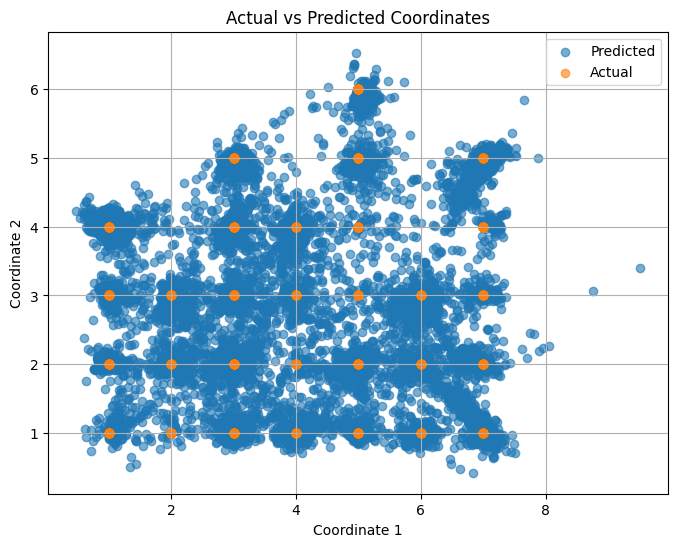

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_np[:, 0], y_pred_np[:, 1], label='Predicted', alpha=0.6)
plt.scatter(y_test_np[:, 0], y_test_np[:, 1], label='Actual', alpha=0.6)
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.title('Actual vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()


In [183]:
# MAE for each coordinate
mae_coord1 = mean_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
mae_coord2 = mean_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

# Overall MAE
mae_overall = np.mean([mae_coord1, mae_coord2])

print(f"MAE for coord1: {mae_coord1:.4f}")
print(f"MAE for coord2: {mae_coord2:.4f}")
print(f"Overall MAE: {mae_overall:.4f}")

# RMSE for each coordinate
rmse_coord1 = np.sqrt(mean_squared_error(y_test_np[:, 0], y_pred_np[:, 0]))
rmse_coord2 = np.sqrt(mean_squared_error(y_test_np[:, 1], y_pred_np[:, 1]))

# Overall RMSE
rmse_overall = np.mean([rmse_coord1, rmse_coord2])

print(f"RMSE for coord1: {rmse_coord1:.4f}")
print(f"RMSE for coord2: {rmse_coord2:.4f}")
print(f"Overall RMSE: {rmse_overall:.4f}")

# Calculate Euclidean distances
distance_errors = np.linalg.norm(y_test_np - y_pred_np, axis=1)
mean_distance_error = np.mean(distance_errors)

print(f"Mean Euclidean Distance Error: {mean_distance_error:.4f} units")

# R-squared for each coordinate
r2_coord1 = r2_score(y_test_np[:, 0], y_pred_np[:, 0])
r2_coord2 = r2_score(y_test_np[:, 1], y_pred_np[:, 1])

print(f"R-squared for coord1: {r2_coord1:.4f}")
print(f"R-squared for coord2: {r2_coord2:.4f}")

# Median Absolute Error for each coordinate
medae_coord1 = median_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
medae_coord2 = median_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Median Absolute Error for coord1: {medae_coord1:.4f}")
print(f"Median Absolute Error for coord2: {medae_coord2:.4f}")

MAE for coord1: 0.0535
MAE for coord2: 0.0379
Overall MAE: 0.0457
RMSE for coord1: 0.2001
RMSE for coord2: 0.1292
Overall RMSE: 0.1647
Mean Euclidean Distance Error: 0.0723 units
R-squared for coord1: 0.9908
R-squared for coord2: 0.9850
Median Absolute Error for coord1: 0.0243
Median Absolute Error for coord2: 0.0130


In [184]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def mean_euclidean_error(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

# Create a scorer based on your custom metric
scorer = make_scorer(mean_euclidean_error, greater_is_better=False)

# Assuming you have a model compatible with scikit-learn's API
scores = cross_val_score(model, X, y, cv=5, scoring=scorer)
print(f"Cross-validated Mean Euclidean Distance Error: {-np.mean(scores):.4f}")


In [185]:
now = datetime.datetime.now()
date_time = now.strftime("%m-%d-%H-%M")

model.save(f"./models/{date_time}-{model_type}-{accuracy:.2f}.keras")